In [105]:
# Import libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,VotingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm
import eli5

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Resources/airbnb_la.csv')

In [3]:
# Total number of rows and columns.
df.shape

(31253, 95)

In [4]:
pd.set_option("display.max_columns", None)
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,NaN,NaN,NaN,NaN,NaN,- No noise/music outside allowed after 10 pm. ...,NaN,NaN,https://a0.muscache.com/im/pictures/dd850460-4...,NaN,54345288,https://www.airbnb.com/users/show/54345288,Robert,2016-01-12,"Los Angeles, California, United States",Thank You for considering my house for your ne...,a few days or more,25%,NaN,f,https://a0.muscache.com/im/pictures/1977b9db-1...,https://a0.muscache.com/im/pictures/1977b9db-1...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Acton, CA 93510, United States",NaN,Acton,NaN,Acton,CA,93510,Other (Domestic),"Acton, CA",US,United States,34.530350,-118.227088,t,House,Entire home/apt,10,7.0,5.0,5.0,Real Bed,"{""Wireless Internet"",""Air conditioning"",Pool,K...",NaN,"$3,000.00",NaN,NaN,"$2,000.00",$200.00,1,$0.00,1,1125,5 months ago,NaN,27,53,82,352,2017-05-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,t,strict,f,f,1,NaN
1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,I'm in the country what's not to love about that,NaN,The train station is only one mile away,Whole house,As much or as little as they want,NaN,https://a0.muscache.com/im/pictures/38165109-1...,https://a0.muscache.com/im/pictures/38165109-1...,https://a0.muscache.com/im/pictures/38165109-1...,https://a0.muscache.com/im/pictures/38165109-1...,44800067,https://www.airbnb.com/users/show/44800067,Kevin,2015-09-22,"Acton, California, United States",NaN,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/287ea76c-1...,https://a0.muscache.com/im/pictures/287ea76c-1...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Palmdale, CA 93550, United States",NaN,Acton,NaN,Palmdale,CA,93550,Other (Domestic),"Palmdale, CA",US,United States,34.485431,-118.125380,f,House,Private room,2,1.0,1.0,1.0,Real Bed,{},NaN,$50.00,NaN,NaN,NaN,NaN,1,$0.00,1,1125,2 months ago,NaN,29,45,75,350,2017-05-03,33,2015-12-04,2017-04-22,93.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,flexible,f,f,1,1.91
2,14078522,https://www.airbnb.com/rooms/14078522,20170502172350,2017-05-03,Room w/private bath on Small Ranch,My place is close to Six Flags Magic Mountain ...,Room with queen bed and private bath,My place is close to Six Flags Magic Mountain ...,none,Horse area. Trails for hiking

### 1. Check nulls and drop columns

In [5]:
# Nulls in each column.
var = df.isnull().sum()

# Nulls are more than half of the rows.
var[var > 15000]

notes                           17438
host_acceptance_rate            31253
neighbourhood_group_cleansed    31253
square_feet                     30869
weekly_price                    23823
monthly_price                   24620
has_availability                31253
license                         31206
dtype: int64

In [6]:
# Drop columns.
df = df.drop(['notes','host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet',
              'has_availability', 'license','weekly_price', 'monthly_price'], axis=1)

In [7]:
df.shape

(31253, 87)

### 2. Initial Selection

In [8]:
# Initial selection of relevant columns.
new_df = df[['host_response_rate','host_is_superhost','host_listings_count',
    'host_total_listings_count','host_has_profile_pic','host_identity_verified',
    'neighbourhood_cleansed','is_location_exact', 'property_type','room_type',
    'accommodates','bathrooms','bedrooms','beds','bed_type','price','security_deposit',
    'cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights', 
    'availability_30', 'availability_60','availability_90', 'availability_365',
    'number_of_reviews','review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication',
    'review_scores_location','review_scores_value', 'requires_license','instant_bookable',
    'cancellation_policy', 'require_guest_profile_picture', 
    'require_guest_phone_verification','calculated_host_listings_count','reviews_per_month']]

new_df.head()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,25%,f,1.0,1.0,t,f,Acton,t,House,Entire home/apt,10,7.0,5.0,5.0,Real Bed,"$3,000.00","$2,000.00",$200.00,1,$0.00,1,1125,27,53,82,352,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,t,strict,f,f,1,NaN
1,100%,t,1.0,1.0,t,f,Acton,f,House,Private room,2,1.0,1.0,1.0,Real Bed,$50.00,NaN,NaN,1,$0.00,1,1125,29,45,75,350,33,93.0,10.0,10.0,10.0,10.0,9.0,9.0,f,f,flexible,f,f,1,1.91
2,100%,t,1.0,1.0,t,t,Acton,t,House,Private room,2,1.0,1.0,1.0,Real Bed,$55.00,NaN,NaN,1,$10.00,1,1125,18,43,73,348,14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,f,f,1,1.72
3,100%,t,1.0,1.0,t,f,Acton,t,Other,Entire home/apt,6,1.0,1.0,3.0,Real Bed,$150.00,NaN,$35.00,1,$0.00,1,2,3,17,30,87,22,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,flexible,f,f,1,2.12
4,NaN,f,1.0,1.0,t,t,Adams-Normandie,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,$30.00,NaN,$5.00,1,$10.00,1,90,0,0,0,0,3,93.0,10.0,9.0,10.0,10.0,9.0,10.0,f,f,flexible,f,f,1,0.18


In [9]:
# print(new_df.columns)

In [10]:
# new_df.shape

### 3. Drop null values

In [11]:
# Nulls in each column.
var = new_df.isnull().sum()
print(var.to_string())

host_response_rate                   5561
host_is_superhost                      14
host_listings_count                    14
host_total_listings_count              14
host_has_profile_pic                   14
host_identity_verified                 14
neighbourhood_cleansed                  0
is_location_exact                       0
property_type                           0
room_type                               0
accommodates                            0
bathrooms                              97
bedrooms                               35
beds                                   59
bed_type                                0
price                                   0
security_deposit                    14397
cleaning_fee                         6974
guests_included                         0
extra_people                            0
minimum_nights                          0
maximum_nights                          0
availability_30                         0
availability_60                   

In [12]:
# Drop all the nulls.
new_df = new_df.dropna()

In [13]:
# Double check the nulls.
# new_df.isnull().sum()

In [14]:
# Check for data types.
new_df.dtypes

host_response_rate                   object
host_is_superhost                    object
host_listings_count                 float64
host_total_listings_count           float64
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_cleansed               object
is_location_exact                    object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price                                object
security_deposit                     object
cleaning_fee                         object
guests_included                       int64
extra_people                         object
minimum_nights                        int64
maximum_nights                        int64
availability_30                 

In [15]:
# Drop duplicates.
# new_df.drop_duplicates

In [16]:
new_df.shape

(11745, 41)

In [18]:
new_df['host_response_rate'].unique()

array(['80%', '96%', '100%', '97%', '82%', '40%', '90%', '94%', '11%',
       '95%', '99%', '93%', '98%', '87%', '83%', '0%', '67%', '75%',
       '50%', '92%', '70%', '33%', '86%', '30%', '43%', '88%', '10%',
       '84%', '89%', '60%', '76%', '29%', '44%', '91%', '63%', '56%',
       '25%', '62%', '78%', '71%', '74%', '65%', '64%', '20%', '81%',
       '72%', '79%', '57%', '69%', '85%', '73%', '17%', '61%', '35%',
       '22%', '68%', '77%', '58%', '39%', '53%', '27%'], dtype=object)

In [19]:
# Convert into a list.
lis = new_df['host_response_rate'].tolist()

# Create a new list.
nlist = []

# Remove % and turn into numeric.
for x in lis:
    nlist.append(int(x.replace(x[-1], ''))/100)

new_df['host_response'] = nlist

#### price

In [20]:
lis = new_df['price'].tolist()

nlist = [int(x.replace(x[0], '').replace('.00', '').replace(',', '')) for x in lis]
             
new_df['Price'] = nlist

#### security_deposit

In [21]:
lis = new_df['security_deposit'].tolist()

nlist = [int(x.replace(x[0], '').replace('.00', '').replace(',', '')) for x in lis]
             
new_df['Security_deposit'] = nlist

#### cleaning_fee

In [22]:
lis = new_df['cleaning_fee'].tolist()

nlist = [int(x.replace(x[0], '').replace('.00', '').replace(',', '')) for x in lis]
             
new_df['Cleaning_fee'] = nlist

#### extra_people

In [23]:
lis = new_df['extra_people'].tolist()

nlist = [int(x.replace(x[0], '').replace('.00', '').replace(',', '')) for x in lis]
             
new_df['Extra_people'] = nlist

In [24]:
# Drop the old columns.
new_df = new_df.drop(['price', 'security_deposit', 'cleaning_fee', 'extra_people'], axis=1)

### 5. Inspect Numeric Columns

In [25]:
# Quantitative Statistics
new_df.describe()

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response,Price,Security_deposit,Cleaning_fee,Extra_people
count,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000
mean,5.656194,5.656194,4.095615,1.426479,1.496211,2.171562,2.180162,3.271775,812.492209,14.220264,32.240187,51.980247,224.656535,30.037974,94.620179,9.658408,9.511537,9.795743,9.792337,9.655428,9.499447,3.895445,1.935613,0.963401,188.714176,421.536654,87.146956,17.681652
std,21.776949,21.776949,2.674808,0.805997,1.101232,1.572967,1.818969,5.973677,9327.872543,10.396569,19.624206,28.821224,121.922064,40.654000,6.822503,0.684686,0.803003,0.553736,0.565115,0.652137,0.737535,5.265609,1.983548,0.117223,270.741429,568.971568,70.815829,25.925319
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000,0.000000,12.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.000000,5.000000,16.000000,29.000000,107.000000,5.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.540000,1.000000,88.000000,150.000000,45.000000,0.000000
50%,2.000000,2.000000,4.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1125.000000,14.000000,32.000000,56.000000,269.000000,15.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.320000,1.000000,125.000000,250.000000,75.000000,10.000000
75%,5.000000,5.000000,5.000000,2.000000,2.000000,3.000000,2.000000,3.000000,1125.000000,24.000000,50.000000,78.000000,336.000000,39.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,2.830000,1.000000,199.000000,500.000000,100.000000,25.000000
max,479.000000,479.000000,16.000000,8.000000,10.000000,16.000000,16.000000,180.000000,1000000.000000,30.000000,60.000000,90.000000,365.000000,532.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,36.000000,90.000000,1.000000,10000.000000,5100.000000,1000.000000,300.000000


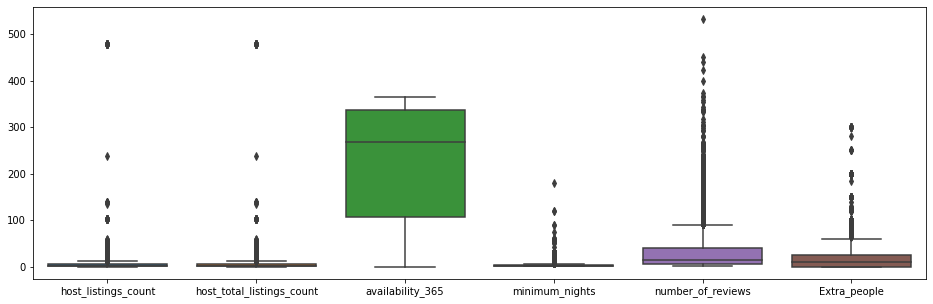

In [159]:
df_1 = new_df[['host_listings_count', 'host_total_listings_count', 'availability_365', 'minimum_nights',
               'number_of_reviews', 'Extra_people']]
plt.rcParams["figure.figsize"] = (16, 5)
sns.boxplot(data=df_1)
plt.show()

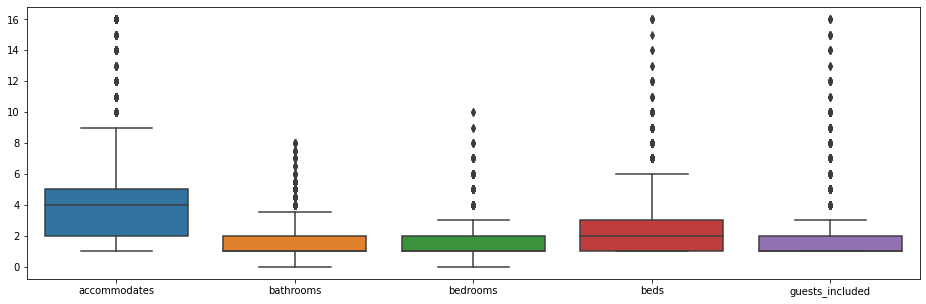

In [160]:
df_2 = new_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included']]
sns.boxplot(data=df_2)
plt.show()

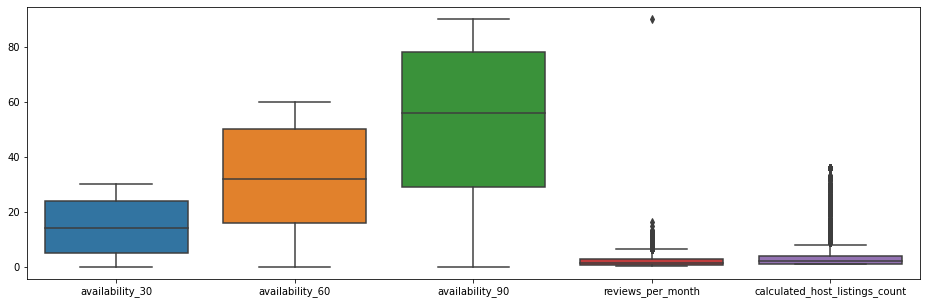

In [161]:
df_3 = new_df[['availability_30', 'availability_60', 'availability_90', 'reviews_per_month', 
               'calculated_host_listings_count']]
sns.boxplot(data=df_3)
plt.show()

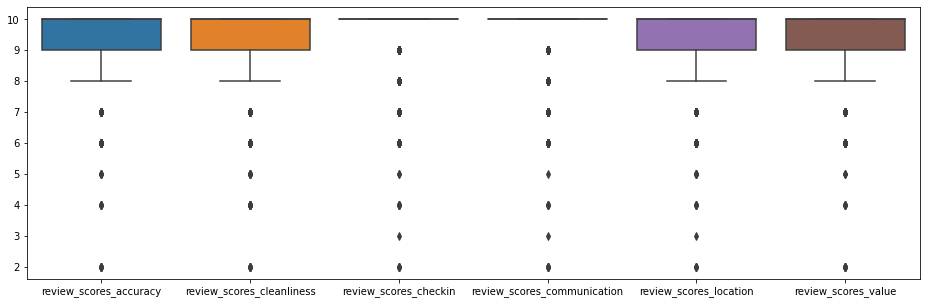

In [162]:
df_4 = new_df[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
               'review_scores_communication', 'review_scores_location', 'review_scores_value']]
sns.boxplot(data=df_4)
plt.show()

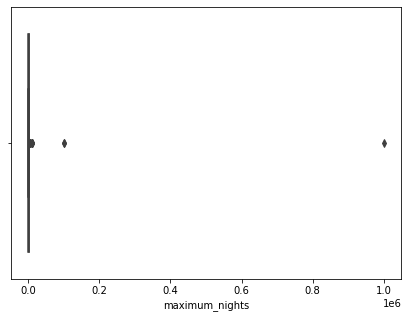

In [173]:
sns.boxplot('maximum_nights', data=new_df)
plt.rcParams["figure.figsize"] = (8, 5)
plt.show()

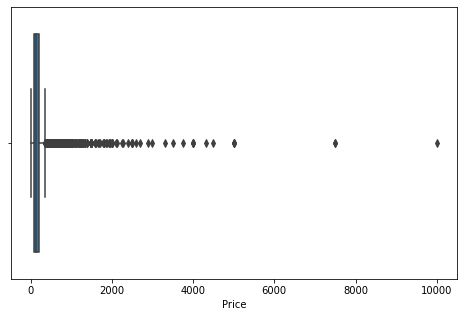

In [174]:
sns.boxplot('Price', data=new_df)
plt.show()

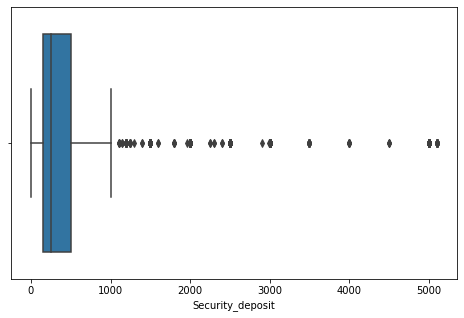

In [175]:
sns.boxplot('Security_deposit', data=new_df)
plt.show()

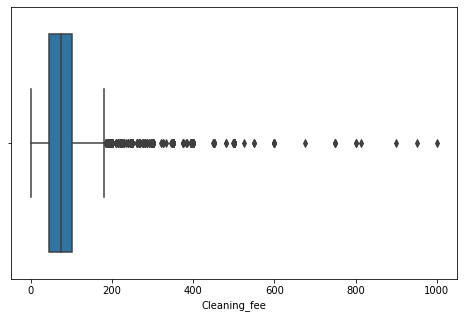

In [176]:
sns.boxplot('Cleaning_fee', data=new_df)
plt.show()

In [177]:
# Filter dataframe.
fil_df = new_df[(new_df.maximum_nights<36500) & (new_df.Price<6000)]
fil_df.shape

(11739, 42)

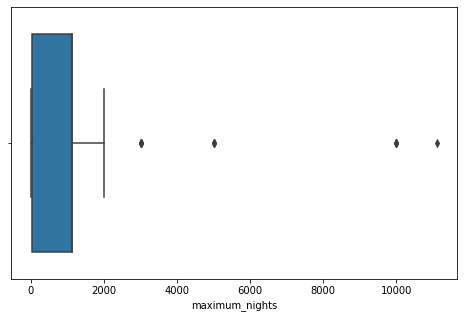

In [178]:
sns.boxplot('maximum_nights', data=fil_df)
plt.show()

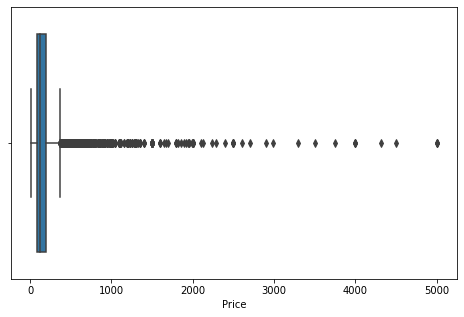

In [179]:
sns.boxplot('Price', data=fil_df)
plt.show()

### 6. Inspect categorical columns

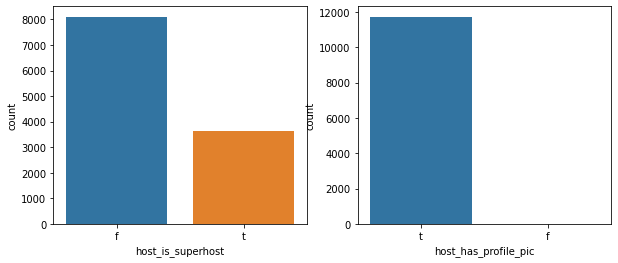

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.countplot('host_is_superhost', data=fil_df, ax=ax1)
sns.countplot('host_has_profile_pic', data=fil_df, ax=ax2)
plt.show()

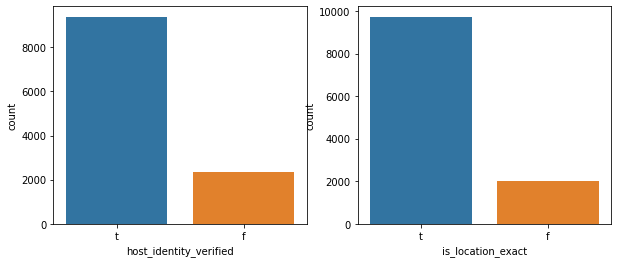

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.countplot('host_identity_verified', data=fil_df, ax=ax1)
sns.countplot('is_location_exact', data=fil_df, ax=ax2)
plt.show()

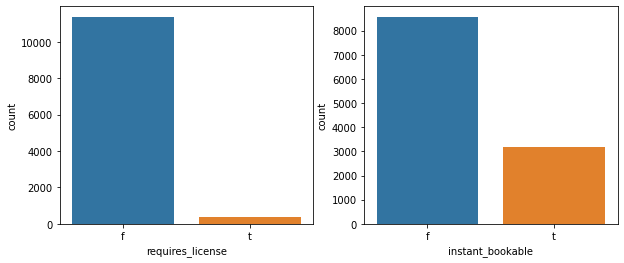

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.countplot('requires_license', data=fil_df, ax=ax1)
sns.countplot('instant_bookable', data=fil_df, ax=ax2)
plt.show()

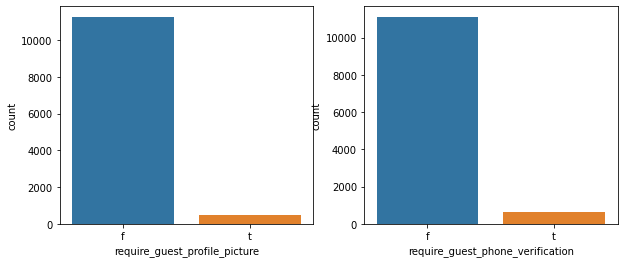

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.countplot('require_guest_profile_picture', data=fil_df, ax=ax1)
sns.countplot('require_guest_phone_verification', data=fil_df, ax=ax2)
plt.show()

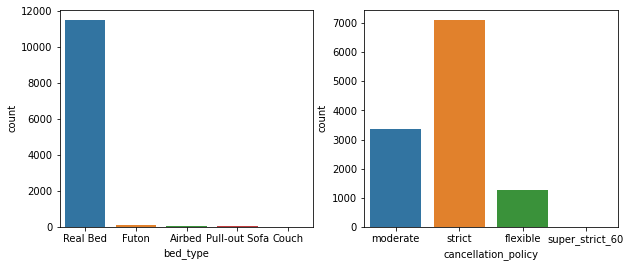

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.countplot('bed_type', data=fil_df, ax=ax1)
sns.countplot('cancellation_policy', data=fil_df, ax=ax2)
plt.show()

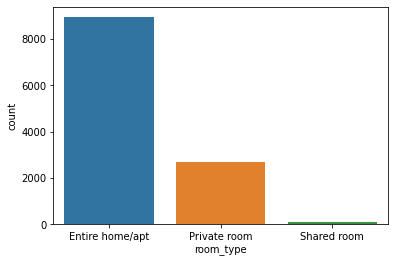

In [42]:
sns.countplot('room_type', data=fil_df)
plt.show()

### 7. Encode categorical to numeric

In [43]:
# Binary encoding. 
encode_df = pd.get_dummies(fil_df, columns=['host_is_superhost', 'host_has_profile_pic', "host_identity_verified", 
                                            'is_location_exact', 'requires_license', "instant_bookable", 
                                            "require_guest_profile_picture", "require_guest_phone_verification"])

# Ordinal Encoding.
ord_enc = OrdinalEncoder()

encode_df["Neighbourhood_cleansed"] = ord_enc.fit_transform(encode_df[["neighbourhood_cleansed"]])

encode_df["Property_type"] = ord_enc.fit_transform(encode_df[["property_type"]])

encode_df["Room_type"] = ord_enc.fit_transform(encode_df[["room_type"]])

encode_df["Bed_type"] = ord_enc.fit_transform(encode_df[["bed_type"]])

encode_df["Cancellation_policy"] = ord_enc.fit_transform(encode_df[["cancellation_policy"]])

In [44]:
# Drop unconverted columns.
encode_df = encode_df.drop(['host_response_rate', 'neighbourhood_cleansed', 'property_type', 'room_type', 
                            'bed_type','cancellation_policy', 'host_is_superhost_f', 'host_has_profile_pic_f',
                            'host_identity_verified_f', 'is_location_exact_f', 'requires_license_f', 'instant_bookable_f', 
                            'require_guest_profile_picture_f', 'require_guest_phone_verification_f'], axis=1)

In [135]:
encode_df.head()

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response,Price,Security_deposit,Cleaning_fee,Extra_people,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,is_location_exact_t,requires_license_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,Neighbourhood_cleansed,Property_type,Room_type,Bed_type,Cancellation_policy
10,1.0,1.0,2,1.0,1.0,1.0,1,1,14,0,6,20,106,15,99.0,10.0,10.0,10.0,10.0,9.0,10.0,1,1.96,0.80,120,100,20,0,0,1,1,1,0,0,0,0,0.0,14.0,0.0,4.0,1.0
12,23.0,23.0,1,0.0,1.0,1.0,1,1,1125,20,46,76,351,19,89.0,9.0,9.0,9.0,9.0,8.0,9.0,19,0.53,0.96,50,100,20,0,0,1,1,1,0,0,0,0,0.0,16.0,1.0,4.0,2.0
15,2.0,2.0,2,1.5,1.0,1.0,2,2,1125,17,41,41,41,27,96.0,10.0,10.0,10.0,10.0,9.0,10.0,2,1.55,1.00,55,100,25,50,1,1,1,0,0,0,0,0,0.0,16.0,1.0,4.0,2.0
19,4.0,4.0,3,1.0,1.0,1.0,2,1,1125,29,59,89,360,4,80.0,8.0,8.0,10.0,10.0,10.0,8.0,1,0.96,0.97,75,300,75,40,0,1,1,1,0,0,0,0,0.0,16.0,1.0,4.0,2.0
20,3.0,3.0,4,2.0,1.0,2.0,1,3,1125,24,48,75,75,16,88.0,9.0,8.0,10.0,10.0,9.0,9.0,3,0.89,1.00,59,150,25,15,0,1,1,1,0,0,0,0,0.0,16.0,1.0,4.0,1.0


## Multiple Linear Regression

In [46]:
# Correlation Matrix
corr_matrix = encode_df.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price                                 1.000000
Cleaning_fee                          0.710443
bathrooms                             0.661170
Security_deposit                      0.633242
bedrooms                              0.578733
accommodates                          0.536682
beds                                  0.486481
guests_included                       0.345914
Extra_people                          0.210176
Property_type                         0.200222
availability_30                       0.139961
Cancellation_policy                   0.128707
availability_60                       0.128240
availability_90                       0.100220
availability_365                      0.099888
review_scores_location                0.070928
maximum_nights                        0.057394
Bed_type                              0.045198
review_scores_rating                  0.044529
review_scores_cleanliness             0.033480
is_location_exact_t                   0.032954
host_identity

In [136]:
# Select variables that are correlated with price.
lr_df = encode_df[['Price', 'Cleaning_fee', 'bathrooms', 'Security_deposit', 'bedrooms', 'accommodates', 'beds', 'guests_included']]
lr_df.head()

,Price,Cleaning_fee,bathrooms,Security_deposit,bedrooms,accommodates,beds,guests_included
10,120,20,1.0,100,1.0,2,1.0,1
12,50,20,0.0,100,1.0,1,1.0,1
15,55,25,1.5,100,1.0,2,1.0,2
19,75,75,1.0,300,1.0,3,1.0,2
20,59,25,2.0,150,1.0,4,2.0,1


In [48]:
# Check for collinearity.
lr_df.corr()

,Price,Cleaning_fee,bathrooms,Security_deposit,bedrooms,accommodates,beds,guests_included
Price,1.000000,0.710443,0.661170,0.633242,0.578733,0.536682,0.486481,0.345914
Cleaning_fee,0.710443,1.000000,0.659220,0.630258,0.641167,0.588941,0.543835,0.420838
bathrooms,0.661170,0.659220,1.000000,0.504352,0.767341,0.653737,0.644597,0.466099
Security_deposit,0.633242,0.630258,0.504352,1.000000,0.441549,0.349473,0.320704,0.259051
bedrooms,0.578733,0.641167,0.767341,0.441549,1.000000,0.772641,0.763579,0.557262
accommodates,0.536682,0.588941,0.653737,0.349473,0.772641,1.000000,0.849013,0.606964
beds,0.486481,0.543835,0.644597,0.320704,0.763579,0.849013,1.000000,0.566642
guests_included,0.345914,0.420838,0.466099,0.259051,0.557262,0.606964,0.566642,1.000000


In [137]:
# bathrooms bedrooms
# bedrooms accommodates beds
lr_df = lr_df.drop(['bathrooms', 'accommodates', 'beds'], axis=1)

In [138]:
lr_df.head()

,Price,Cleaning_fee,Security_deposit,bedrooms,guests_included
10,120,20,100,1.0,1
12,50,20,100,1.0,1
15,55,25,100,1.0,2
19,75,75,300,1.0,2
20,59,25,150,1.0,1


### QQ Plot & Shapiro-Wilk Test

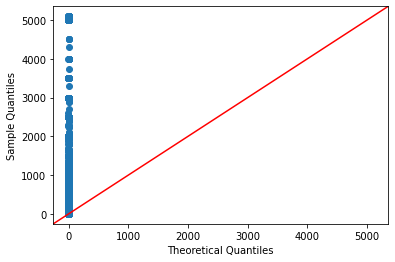

In [50]:
fig = sm.qqplot(lr_df, line='45')
plt.show()

In [51]:
stats.shapiro(lr_df)

ShapiroResult(statistic=0.40516597032546997, pvalue=0.0)

### Linear Regression Model 1

In [145]:
# Define X and y
X = lr_df.drop('Price', axis=1)

# Add constant to predictor variables
X = sm.add_constant(X)

y = lr_df.Price

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [146]:
# Fit linear regression model
lr_model = sm.OLS(y_train, X_train).fit()

In [147]:
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     3432.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:42:39   Log-Likelihood:                -56449.
No. Observations:                8804   AIC:                         1.129e+05
Df Residuals:                    8799   BIC:                         1.129e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -46.5588      2.860  

In [148]:
# Predictions.
y_pred = lr_model.predict(X_test)

# Mean Squared Error.
MSE(y_test, y_pred)

28321.222819952258

In [149]:
np.mean(abs(lr_df.Price - y_pred))

73.04543123509119

In [150]:
lr_model.mse_resid

21723.661036944177

In [151]:
# Residual Standard Error.
np.sqrt(lr_model.mse_resid)

147.38948753877997

In [152]:
# Multiple R-squared with cross-validation.
model = LinearRegression()
cv_res = cross_val_score(model, X_train, y_train, cv=5)

# Compute the mean.
np.mean(cv_res)

0.6021905941590899

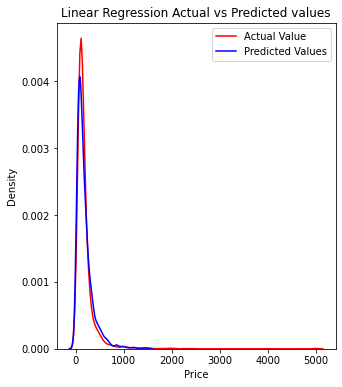

In [153]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Linear Regression Actual vs Predicted values')
plt.legend()
plt.show()

### Linear Regression Model 2

In [139]:
# Define X and y
X = lr_df.drop(['Price', 'guests_included'], axis=1)

# Add constant to predictor variables
X = sm.add_constant(X)

y = lr_df.Price

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [140]:
# Scale the data.
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [141]:
lr = sm.OLS(y_train, X_train).fit()
print(lr.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.373
Model:                            OLS   Adj. R-squared (uncentered):              0.373
Method:                 Least Squares   F-statistic:                              1748.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                        0.00
Time:                        15:40:34   Log-Likelihood:                         -60686.
No. Observations:                8804   AIC:                                  1.214e+05
Df Residuals:                    8801   BIC:                                  1.214e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [143]:
# Predictions.
y_pred = lr.predict(X_test)
MSE(y_test, y_pred)

62396.99222240908

## Feature Selection

In [115]:
X = encode_df.drop('Price', axis=1)
y = encode_df.Price

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### 1. Random Forest Regressor

In [66]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.1)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=0.1, n_estimators=1000)

In [67]:
rf.score(X_train, y_train)

0.3216313640958105

In [68]:
rf.score(X_test, y_test)

0.2941453682838918

In [69]:
# Testing Set Mean Squared Error.
y_pred = rf.predict(X_test)
MSE(y_test, y_pred)

40461.43771115184

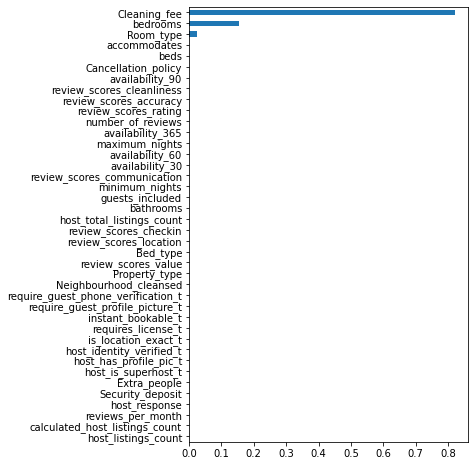

In [70]:
# Feature Importance.
im_rf = pd.Series(rf.feature_importances_, index=X.columns)

sort_im = im_rf.sort_values()
plt.figure(figsize=(5,8))
sort_im.plot(kind='barh')
plt.show()

### 2. Lasso Regression

In [116]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [117]:
eli5.show_weights(lasso, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+80.988,bathrooms
+36.753,requires_license_t
+10.624,accommodates
+8.238,review_scores_location
+3.675,instant_bookable_t
+1.835,review_scores_rating
+1.175,Cleaning_fee
+0.983,host_identity_verified_t
+0.517,availability_60
+0.383,Property_type


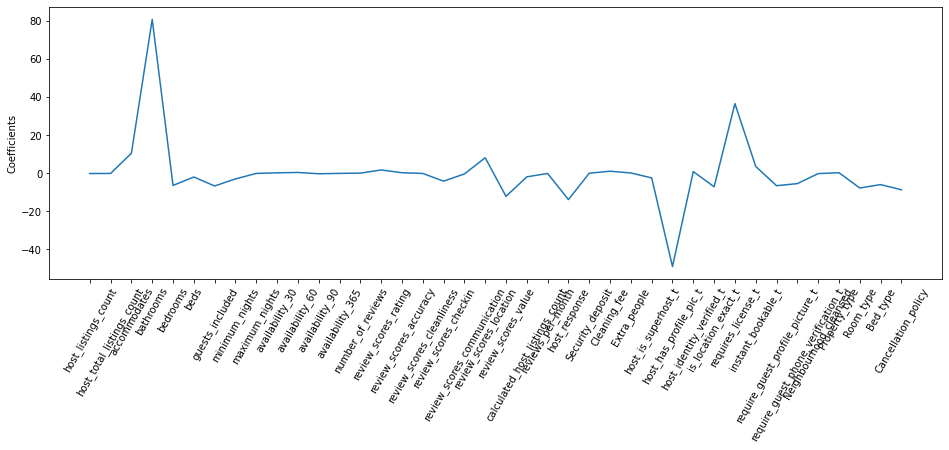

In [118]:
names = X.columns
plt.plot(range(len(names)), lasso.coef_)
plt.rcParams["figure.figsize"] = (16, 5)
plt.xticks(range(len(names)), names, rotation=60)
plt.ylabel('Coefficients')
plt.show()

## More models

In [121]:
# Selected columns.
sel_df = encode_df[['Cleaning_fee', 'bedrooms', 'bathrooms', 'requires_license_t', 'Price']]
sel_df.head()

,Cleaning_fee,bedrooms,bathrooms,requires_license_t,Price
10,20,1.0,1.0,0,120
12,20,1.0,0.0,0,50
15,25,1.0,1.5,0,55
19,75,1.0,1.0,0,75
20,25,1.0,2.0,0,59


In [122]:
X = sel_df.drop('Price', axis=1)
y = sel_df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### 1. Ada Boost

In [76]:
rf = RandomForestRegressor()

ada = AdaBoostRegressor(base_estimator=rf, n_estimators=600)
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(), n_estimators=600)

In [77]:
ada.score(X_train, y_train)

0.8141029195251646

In [78]:
ada.score(X_test, y_test)

0.4134121042368719

In [80]:
# Mean Squared Error.
y_pred = ada.predict(X_test)
MSE(y_test, y_pred)

33624.755778440835

### 2. Gradient Boost

In [81]:
gb = GradientBoostingRegressor(n_estimators=600, max_depth=3)
gb.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=600)

In [82]:
gb.score(X_train, y_train)

0.8262573092927425

In [83]:
gb.score(X_test, y_test)

0.4638953071596942

In [84]:
# Mean Squared Error.
y_pred = gb.predict(X_test)
MSE(y_test, y_pred)

30730.92625782823

### 3. Random Forest CV

In [123]:
grid = {'n_estimators': np.arange(100, 1000, 100), 
        'max_depth': np.arange(2, 10),
        'min_samples_leaf': [0.1, 0.2, 0.3],
        'max_features': ['log2', 'sqrt']}

rf = RandomForestRegressor()
rf_cv = RandomizedSearchCV(rf, grid, cv=10, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [0.1, 0.2, 0.3],
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   verbose=1)

In [124]:
rf_cv.best_score_

0.34482257899333224

In [125]:
rf_cv.score(X_test, y_test)

0.30899604792694246

In [126]:
# Mean Squared Error.
y_pred = rf_cv.predict(X_test)
MSE(y_test, y_pred)

39610.15782667382

In [127]:
# rmse.
np.sqrt(MSE(y_test, y_pred))

199.02300828465494

### 4. Ridge CV

In [89]:
grid = {'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 
              1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]} 
ridge = Ridge(normalize=True)
ridge_cv = RandomizedSearchCV(ridge, grid, cv=10, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=Ridge(normalize=True), n_jobs=-1,
                   param_distributions={'alpha': [1e-15, 1e-10, 1e-08, 0.0009,
                                                  0.0007, 0.0005, 0.0003,
                                                  0.0001, 0.001, 0.05, 0.01,
                                                  0.1, 0.3, 1, 3, 5, 10, 15, 18,
                                                  20, 30, 50, 75, 100]},
                   verbose=1)

In [91]:
ridge_cv.score(X_test, y_test)

0.492112861144268

In [92]:
ridge_cv.best_score_

0.5946205561504245

In [93]:
ridge_cv.best_params_

{'alpha': 0.05}

In [94]:
# Mean Squared Error.
y_pred = ridge_cv.predict(X_test)
MSE(y_test, y_pred)

29113.422098179824

### 5. Lasso CV

In [97]:
grid = {'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 
              1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]}

lasso = Lasso(normalize=True)
lasso_cv = RandomizedSearchCV(lasso, grid, cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=Lasso(normalize=True), n_jobs=-1,
                   param_distributions={'alpha': [1e-15, 1e-10, 1e-08, 0.0009,
                                                  0.0007, 0.0005, 0.0003,
                                                  0.0001, 0.001, 0.05, 0.01,
                                                  0.1, 0.3, 1, 3, 5, 10, 15, 18,
                                                  20, 30, 50, 75, 100]},
                   verbose=1)

In [98]:
lasso_cv.score(X_test, y_test)

0.4894347165433881

In [99]:
lasso_cv.best_score_

0.5940132409147802

In [100]:
# Mean Squared Error.
y_pred = lasso_cv.predict(X_test)
MSE(y_test, y_pred)

29266.940366787774

### 6. Voting Regressor

In [154]:
lr = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

regressor = [('Linear Regression', lr),('Random Forest', rf), ('Gadient Boosting', gb)]

vc = VotingRegressor(estimators=regressor)
vc.fit(X_train, y_train)

VotingRegressor(estimators=[('Linear Regression', LinearRegression()),
                            ('Random Forest', RandomForestRegressor()),
                            ('Gadient Boosting', GradientBoostingRegressor())])

In [155]:
vc.score(X_train, y_train)

0.8172237798120671

In [156]:
vc.score(X_test, y_test)

0.5583525896280139

In [157]:
# Mean Squared Error.
y_pred = vc.predict(X_test)
MSE(y_test, y_pred)

25316.387230628454

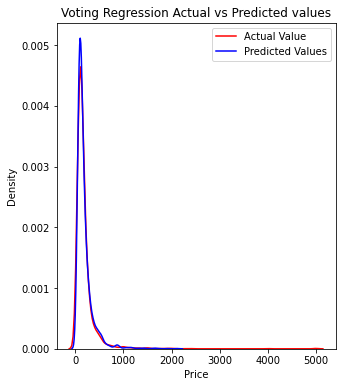

In [158]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Voting Regression Actual vs Predicted values')
plt.legend()
plt.show()